In [9]:
%run '00_sim_fns.ipynb'

Making base model....
Done!


In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Functions

In [11]:
def read_result(data_dir, base_name):
    '''
    Read all the data into one massive array.
    May not be such a great idea for large datasets.
    '''
    fns = file_list(data_dir, base_name)
    dfs = []
    for fn in fns:
        dfs.append(pickle.load(open(fn, 'rb')))
    df = pd.concat(dfs)
    df = df.reset_index(drop=True)
    return df

In [12]:
def build_multihist(data_dir, base_name, bins, hist_range):
    '''
    Read files and build the hist using that.
    '''
    keys = ['lr', 'cs1', 'cs2']
    m = Histdd(bins=bins, range=hist_range, axis_names = keys)
    fns = file_list(data_dir, base_name)
    dfs = []
    for fn in fns:
        df = pickle.load(open(fn, 'rb'))
        m.add(*[df[key].values for key in keys])
    print('Read %d files from base %s, total %.1f M events' % (len(fns), base_name, m.n/(1e6)))

    return m

In [13]:
def add_to_hist(m, data_dir, base_name):
    keys = ['lr', 'cs1', 'cs2']
    fns = file_list(data_dir, base_name)
    print('Reading %d files...' % (len(fns)))
    dfs = []
    for fn in fns:
        df = pickle.load(open(fn, 'rb'))
        m.add(*[df[key].values for key in keys])
    
    return m

In [14]:
def build_disc(m_er, m_wimp, plot=False, mode='new', num_fom = 100):
    '''
    Build the ER and NR discrimination, based on histograms. The hists may be 2D or 3D.
    Output: wimpacc, eracc
    '''
    if mode == 'old':
        print('You are using mode old. This will throw a divide by zero warning, it should do that, dont worry.')
        offset = 0
        fom = (m_wimp + offset) / (m_er + offset) 
        fom.histogram = np.log10(fom.histogram)
        valid = ~np.isnan(fom.histogram)
        
        
    elif mode == 'new':
        no_er   = m_er.histogram == 0
        no_wimp = m_wimp.histogram == 0
        valid = ~(no_er & no_wimp)
    
        offset = 1e-30
        offscale = 42
        fom = (m_wimp + offset) / (m_er + offset) 
        fom.histogram = np.log10(fom.histogram)
        # No er is good means positive
        fom.histogram[no_er] = offscale
        fom.histogram[no_wimp] = - offscale
    
    bounds = (-6, 6)
    bins = np.linspace(*bounds, num=num_fom)
    hists = dict()
    for label, q in ('er', m_er), ('wimp', m_wimp):
        hists[label] = h = Hist1d(
            # Clip values to fall inside bins
            np.clip(fom.histogram[valid], bounds[0], bounds[-1] - 1e-7),
            weights=q.histogram[valid],
            bins=bins
        )
    if plot:
        for label in ['er', 'wimp']:
            hists[label].plot(label=label)
        plt.legend(loc='upper right')
        plt.xlabel("Wimpiness")
        plt.ylabel("Fraction in bin")
        
    eracc   = 1 - hists['er'].cumulative_density
    wimpacc = 1 - hists['wimp'].cumulative_density
    
    return wimpacc, eracc

In [15]:
def build_multihist_no_lr(source, ntrials, n_per_trial, bins, hist_range):
    '''
    
    '''
    keys = ['cs1', 'cs2']
    m = Histdd(bins=bins, range=hist_range, axis_names = keys)
    
    model = bi.Model(base_model.config)
    if source == 'er':
        generator = model.sources[0]
    elif source == 'wimp':
        generator = model.sources[-1] 
    for i in tqdm(range(ntrials), desc = 'Building %s' % source):
        df = pd.DataFrame(generator.simulate(n_per_trial))
        m.add(*[df[key].values for key in keys])
    return m


## Reading

### Check range

In [16]:
df_w = read_result(data_dir, 'wimp_50GeV_tts10.0ns_500k')
df_er= read_result(data_dir, 'er_tts5.0ns_500k')

In [17]:
for key in ['cs1', 'cs2', 'lr']:
    _min = np.min([np.min(df[key]) for df in [df_w, df_er]])
    _max = np.max([np.max(df[key]) for df in [df_w, df_er]])
    print('%s range detected from %.1f to %.1f' % (key, _min, _max))

cs1 range detected from 0.1 to 179.3
cs2 range detected from 186.1 to 7317.3
lr range detected from -10.5 to 17.1


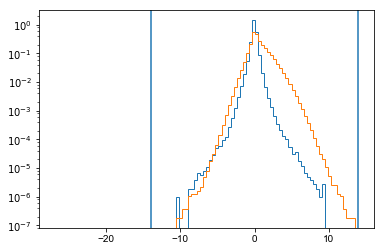

In [18]:

for df in [df_w, df_er]:
    plt.hist(df['lr'], bins=100, histtype='step', normed = True, range=(-27, 14))
plt.yscale('log')
limits = [-14, 14]
for _l in limits:
    plt.axvline(_l)

### Build histograms

In [19]:
# These are the bin edges by Jelle
# Note that the acceptance percentage will be as fraction of events within analysis range...
bin_edges = [
    np.linspace(-15, 15, 61),
    np.linspace(3, 70, 68),
    np.logspace(np.log10(50), np.log10(8000), 71)]

In [20]:
m = {}
tres = [1, 2, 5, 10]
wimp_masses = [500] #[20, 50, 500]

names  = np.concatenate([['er_%d' % t for t in tres], ['wimp%d_%d' % (wimp_mass, t) for t in tres 
                                                                                    for wimp_mass in wimp_masses]])
fullnames = np.concatenate([['er_tts%.1fns_500k' % t for t in tres], 
                            ['wimp_%dGeV_tts%.1fns_500k' % (wimp_mass, t) for t in tres
                                                                          for wimp_mass in wimp_masses]])
for key, fullname in zip(names, fullnames):
    m[key] = build_multihist(data_dir, fullname, bin_edges, [(min(edges), max(edges)) for edges in bin_edges])

Read 40 files from base er_tts1.0ns_500k, total 11.6 M events
Read 30 files from base er_tts2.0ns_500k, total 8.7 M events
Read 30 files from base er_tts5.0ns_500k, total 8.7 M events
Read 28 files from base er_tts10.0ns_500k, total 8.2 M events
Read 38 files from base wimp_500GeV_tts1.0ns_500k, total 12.3 M events
Read 27 files from base wimp_500GeV_tts2.0ns_500k, total 8.8 M events
Read 27 files from base wimp_500GeV_tts5.0ns_500k, total 8.8 M events
Read 28 files from base wimp_500GeV_tts10.0ns_500k, total 9.1 M events


### Build discrimination

In [21]:
disc = {}
for dt in tres:
    for wimp_mass in wimp_masses:
        disc['%dgev_%dns' % (wimp_mass, dt)] = build_disc(m['er_%d' % dt], m['wimp%d_%d' % (wimp_mass, dt)])

In [22]:
disc_nopsd = {}
for wimp_mass in wimp_masses:
    disc_nopsd['%dgev' % wimp_mass] = build_disc(m['er_%d' % dt].sum('lr'), m['wimp%d_%d' % (wimp_mass, dt)].sum('lr'))

### Discrimination PSD only...

In [23]:
# Make sure it is the same range in all parameters
bin_edges_psd_only = [
    np.linspace(-15, 15, 1001),
    np.linspace(3, 70, 2),
    np.logspace(np.log10(50), np.log10(8000), 2)]
_m = {}
for key, fullname in zip(names, fullnames):
    _m[key] = build_multihist(data_dir, fullname, bin_edges_psd_only, 
                              [(min(edges), max(edges)) for edges in bin_edges_psd_only])
    _m[key] = _m[key].sum('cs1').sum('cs2')

Read 40 files from base er_tts1.0ns_500k, total 11.6 M events
Read 30 files from base er_tts2.0ns_500k, total 8.7 M events
Read 30 files from base er_tts5.0ns_500k, total 8.7 M events
Read 28 files from base er_tts10.0ns_500k, total 8.2 M events
Read 38 files from base wimp_500GeV_tts1.0ns_500k, total 12.3 M events
Read 27 files from base wimp_500GeV_tts2.0ns_500k, total 8.8 M events
Read 27 files from base wimp_500GeV_tts5.0ns_500k, total 8.8 M events
Read 28 files from base wimp_500GeV_tts10.0ns_500k, total 9.1 M events


In [24]:
disc_psd = {}
for dt in tres:
    for wimp_mass in wimp_masses:
        disc_psd['%dgev_%dns' % (wimp_mass, dt)] = build_disc(_m['er_%d' % dt], _m['wimp%d_%d' % (wimp_mass, dt)],
                                                              num_fom =1000)

In [26]:
# _m['er_2'].plot()
# _m['wimp50_2'].plot()
# plt.yscale('log')

### Compare results

In [27]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [28]:
def interpolate_acc(acc_tuple, er_acc = 0.5e-2):
    eracc = acc_tuple[1]
    wimpacc = acc_tuple[0]
    return np.interp(er_acc, list(reversed(eracc)), list(reversed(wimpacc)))

In [29]:
wimp_mass = 20
plt.plot(*disc_nopsd['%dgev' % wimp_mass], label='S1/S2 only', color='black')
plt.plot(*disc['%dgev_10ns' % wimp_mass], label='Including PSD, 10 ns', ls='--')

plt.plot(*disc['%dgev_2ns' % wimp_mass], label='Including PSD, 2 ns', color='green', ls='dotted')
# plt.plot(*disc['%dgev_5ns' % wimp_mass], label='Including PSD, 5 ns')
plt.plot(*disc_psd['%dgev_2ns' % wimp_mass], label='PSD only, 2 ns', lw=2, color='blue')
plt.xlabel('\SI{500}{GeV} WIMP acceptance')
plt.ylabel('ER acceptance')
plt.yscale('log')
plt.axhline(5e-3, ls='--', color='red')
plt.xlim(0, 1)
plt.ylim(1e-4, 1)
plt.legend(loc=(0, -0.65))
# plt.title(r'\bf %d GeV WIMP' % wimp_mass)
plt.text(0.15, 0.007, '99.5\% rejection', color='red')

acc_no_psd = interpolate_acc(disc_nopsd['%dgev' % wimp_mass], 5e-3)
acc_psd =  interpolate_acc(disc['%dgev_2ns' % wimp_mass], 5e-3)
print("Increase from %f to %f at 0.5%% ER leakage, %.3f percent increase!" 
      % (acc_no_psd, acc_psd, (acc_psd/acc_no_psd - 1) * 100))
plt.savefig('/home/erik/win/notes/wimpacc.pdf', bbox_inches = 'tight')

KeyError: '20gev'

Increase from 0.537641 to 0.574232 at 0.5% ER leakage, 6.8 percent increase!


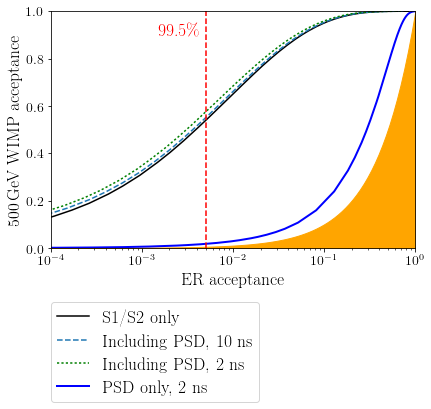

In [30]:
wimp_mass = 500

def rev(tup):
    return (tup[1], tup[0])

plt.plot(*rev(disc_nopsd['%dgev' % wimp_mass]), label='S1/S2 only', color='black')
plt.plot(*rev(disc['%dgev_10ns' % wimp_mass]), label='Including PSD, 10 ns', ls='--')

plt.plot(*rev(disc['%dgev_2ns' % wimp_mass]), label='Including PSD, 2 ns', color='green', ls='dotted')
# plt.plot(*disc['%dgev_5ns' % wimp_mass], label='Including PSD, 5 ns')
plt.plot(*rev(disc_psd['%dgev_2ns' % wimp_mass]), label='PSD only, 2 ns', lw=2, color='blue')


monkey = np.logspace(-4, 0, 100)
# plt.plot(monkey, monkey, label='Random cut ($y = x$)')
plt.fill_between(monkey, monkey, color='orange')

plt.ylabel('\SI{500}{GeV} WIMP acceptance')
plt.xlabel('ER acceptance')
plt.xscale('log')
plt.axvline(5e-3, ls='--', color='red')
plt.ylim(0, 1)
plt.xlim(1e-4, 1)
plt.legend(loc=(0, -0.65))
# plt.title(r'\bf %d GeV WIMP' % wimp_mass)
plt.text(0.0015, 0.9, '99.5\%', color='red', rotation = 0)

acc_no_psd = interpolate_acc(disc_nopsd['%dgev' % wimp_mass], 5e-3)
acc_psd =  interpolate_acc(disc['%dgev_2ns' % wimp_mass], 5e-3)
print("Increase from %f to %f at 0.5%% ER leakage, %.1f percent increase!" 
      % (acc_no_psd, acc_psd, (acc_psd/acc_no_psd - 1) * 100))
plt.savefig('/home/erik/win/notes/wimpacc.pdf', bbox_inches = 'tight')

Increase from 0.537641 to 0.601056 at 0.5% ER leakage, 11.8 percent increase!


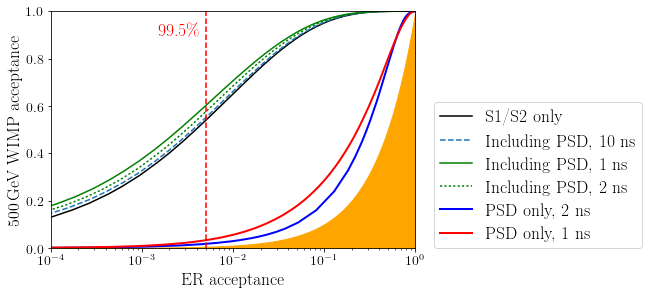

In [31]:
wimp_mass = 500

def rev(tup):
    return (tup[1], tup[0])

plt.plot(*rev(disc_nopsd['%dgev' % wimp_mass]), label='S1/S2 only', color='black')
plt.plot(*rev(disc['%dgev_10ns' % wimp_mass]), label='Including PSD, 10 ns', ls='--')

plt.plot(*rev(disc['%dgev_1ns' % wimp_mass]), label='Including PSD, 1 ns', color='green', ls='solid')
plt.plot(*rev(disc['%dgev_2ns' % wimp_mass]), label='Including PSD, 2 ns', color='green', ls='dotted')
# plt.plot(*disc['%dgev_5ns' % wimp_mass], label='Including PSD, 5 ns')
plt.plot(*rev(disc_psd['%dgev_2ns' % wimp_mass]), label='PSD only, 2 ns', lw=2, color='blue')
plt.plot(*rev(disc_psd['%dgev_1ns' % wimp_mass]), label='PSD only, 1 ns', lw=2, color='red')

monkey = np.logspace(-4, 0, 100)
# plt.plot(monkey, monkey, label='Random cut ($y = x$)')
plt.fill_between(monkey, monkey, color='orange')

plt.ylabel('\SI{500}{GeV} WIMP acceptance')
plt.xlabel('ER acceptance')
plt.xscale('log')
plt.axvline(5e-3, ls='--', color='red')
plt.ylim(0, 1)
plt.xlim(1e-4, 1)
plt.legend(loc=(1.05, 0))
# plt.title(r'\bf %d GeV WIMP' % wimp_mass)
plt.text(0.0015, 0.9, '99.5\%', color='red', rotation = 0)

acc_no_psd = interpolate_acc(disc_nopsd['%dgev' % wimp_mass], 5e-3)
acc_psd =  interpolate_acc(disc['%dgev_1ns' % wimp_mass], 5e-3)
print("Increase from %f to %f at 0.5%% ER leakage, %.1f percent increase!" 
      % (acc_no_psd, acc_psd, (acc_psd/acc_no_psd - 1) * 100))
plt.savefig('/home/erik/win/notes/wimpacc.pdf', bbox_inches = 'tight')

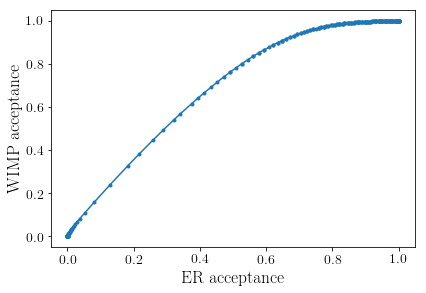

In [32]:
plt.plot(disc_psd['500gev_2ns'][1], disc_psd['500gev_2ns'][0], marker='.')
plt.xlabel('ER acceptance')
plt.ylabel('WIMP acceptance')

Increase from 0.537641 to 0.601056 at 0.5% ER leakage, 11.8 percent increase!


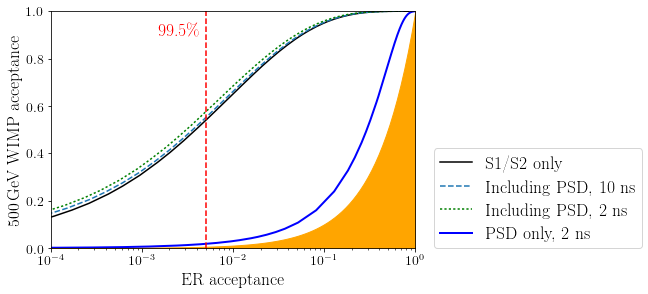

In [34]:
wimp_mass = 500

def rev(tup):
    return (tup[1], tup[0])

plt.plot(*rev(disc_nopsd['%dgev' % wimp_mass]), label='S1/S2 only', color='black')
plt.plot(*rev(disc['%dgev_10ns' % wimp_mass]), label='Including PSD, 10 ns', ls='--')

plt.plot(*rev(disc['%dgev_2ns' % wimp_mass]), label='Including PSD, 2 ns', color='green', ls='dotted')
# plt.plot(*disc['%dgev_5ns' % wimp_mass], label='Including PSD, 5 ns')
plt.plot(*rev(disc_psd['%dgev_2ns' % wimp_mass]), label='PSD only, 2 ns', lw=2, color='blue')

monkey = np.logspace(-4, 0, 100)
# plt.plot(monkey, monkey, label='Random cut ($y = x$)')
plt.fill_between(monkey, monkey, color='orange')

plt.ylabel('\SI{500}{GeV} WIMP acceptance')
plt.xlabel('ER acceptance')
plt.xscale('log')
plt.axvline(5e-3, ls='--', color='red')
plt.ylim(0, 1)
plt.xlim(1e-4, 1)
plt.legend(loc=(1.05, 0))
# plt.title(r'\bf %d GeV WIMP' % wimp_mass)
plt.text(0.0015, 0.9, '99.5\%', color='red', rotation = 0)

acc_no_psd = interpolate_acc(disc_nopsd['%dgev' % wimp_mass], 5e-3)
acc_psd =  interpolate_acc(disc['%dgev_1ns' % wimp_mass], 5e-3)
print("Increase from %f to %f at 0.5%% ER leakage, %.1f percent increase!" 
      % (acc_no_psd, acc_psd, (acc_psd/acc_no_psd - 1) * 100))
plt.savefig('/home/erik/win/notes/fig12.pdf', bbox_inches = 'tight')

### Try higher stats

In [156]:
m = {}
for key in ['er', 'wimp']:
    m[key] = build_multihist_no_lr(key, 10, 500000, bin_edges_JA, hist_range=((3, 70), (50, 8000)))

Building wimp: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


You are using mode old. This will throw a divide by zero warning, it should do that, dont worry.


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: invalid value encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


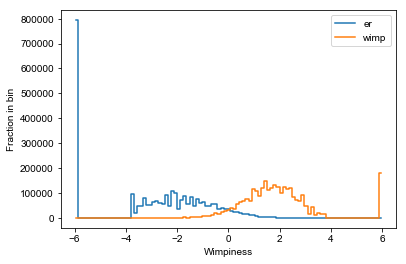

In [157]:
eracc_histat, wimpacc_histat = build_disc(m['er'], m['wimp'], plot=True, num_fom=100)

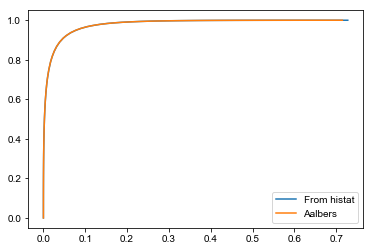

In [160]:
# plt.plot(eracc, wimpacc, label='From full simulation')
plt.plot(eracc_histat, wimpacc_histat, label='From histat')
plt.plot(eracc_ja, wimpacc_ja, label='Aalbers')
plt.legend()

### Old vs new mode

You are using mode old. This will throw a divide by zero warning, it should do that, dont worry.


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/multihist-0.5.2-py3.4.egg/multihist.py:91: RuntimeWarning: invalid value encountered in true_divide
  return self.__class__.from_histogram(self.histogram.__truediv__(other), self.bin_edges, self.axis_names)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


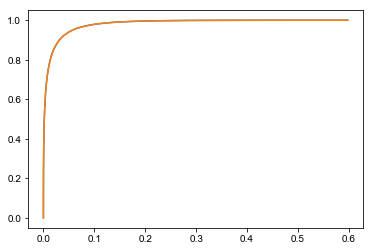

In [129]:
for mode in ['old', 'new']:
    eracc, wimpacc = build_disc(m['er'].sum('lr'), m['wimp'].sum('lr'), plot=False, mode=mode)
    plt.plot(eracc, wimpacc)